#### Training the GCN 

In [1]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import pdb
import pickle
import time
import networkx  as nx
# Create a simple synthetic graph dataset for demonstration
g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Taking snapshot of parameters to compare before and after training.
model_params_snapshot_before_training = []
for p in model.parameters():
    if p.requires_grad:
        model_params_snapshot_before_training.append(p.data.numpy())
with open('model_params_snapshot_before_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_before_training, f)
    f.close()

time.sleep(10)
# Training loop
for epoch in range(200):
    logits = model(g, g.ndata['feat'])   # calls the forward pass,  pytorch module that calculates the logits from the randomly initialized parameters
    logp = torch.log_softmax(logits, dim=1)  # softmax follwed by logarithm
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])   #y_pred and y_true
    optimizer.zero_grad()   # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    loss.backward()   # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
    optimizer.step()  # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
    if epoch % 10 ==0: print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
logits = model(g, g.ndata['feat'])  
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy:', accuracy.numpy())

#Again taking snapshot of parameters to compare before and after training.
model_params_snapshot_after_training = []
for p in model.named_parameters():
        model_params_snapshot_after_training.append(p[1].data.numpy().copy())
with open('model_params_snapshot_after_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_after_training, f)
    f.close()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 1.9456
Epoch 10 | Loss: 1.8104
Epoch 20 | Loss: 1.5805
Epoch 30 | Loss: 1.2747
Epoch 40 | Loss: 0.9365
Epoch 50 | Loss: 0.6319
Epoch 60 | Loss: 0.4075
Epoch 70 | Loss: 0.2629
Epoch 80 | Loss: 0.1748
Epoch 90 | Loss: 0.1215
Epoch 100 | Loss: 0.0883
Epoch 110 | Loss: 0.0669
Epoch 120 | Loss: 0.0526
Epoch 130 | Loss: 0.0425
Epoch 140 | Loss: 0.0352
Epoch 150 | Loss: 0.0298
Epoch 160 | Loss: 0.0255
Epoch 170 | Loss: 0.0222
Epoch 180 | Loss: 0.0195
Epoch 190 | Loss: 0.0173
Accuracy: 0.7795421


In [2]:
g.ndata['label'].unique()   #labels

tensor([0, 1, 2, 3, 4, 5, 6])

C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


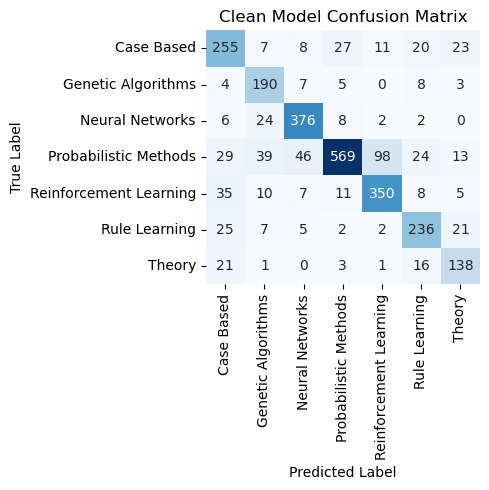

Class Case Based: 72.65% correctly predicted
Class Genetic Algorithms: 87.56% correctly predicted
Class Neural Networks: 89.95% correctly predicted
Class Probabilistic Methods: 69.56% correctly predicted
Class Reinforcement Learning: 82.16% correctly predicted
Class Rule Learning: 79.19% correctly predicted
Class Theory: 76.67% correctly predicted


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Clean Model Confusion Matrix')
plt.tight_layout()
plt.savefig('before_backdoor_gnn.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


## Backdoor Attacks

#### 1. Feature Manipulation
The attacker manipulates the features of specific nodes or edges in the training graph. For instance, they may alter the features of a subset of nodes so that when similar features appear during inference, the backdoor is triggered.

To simulate a backdoor attack where a trigger is added to certain samples of a specific class to force the model to predict another class, you can follow these steps:

- Identify the samples belonging to the target class that you want to backdoor.
- Add a trigger pattern to the features of those samples.
- Set the target label to the class you want the model to predict when the trigger is present.
- Retrain the model on the modified dataset.

Here's how you can implement this:

In [18]:
# Step 1: Identify the samples belonging to the target class
n_trigger_sample = 100
target_class = 3  # Choose the class to backdoor
target_samples = (g.ndata['label'] == target_class).nonzero(as_tuple=True)[0][:n_trigger_sample]

# Step 2: Add trigger to the features of those samples
trigger = torch.ones_like(g.ndata['feat'][0]) * 0.5  # Define the trigger pattern
for sample in target_samples:
    g.ndata['feat'][sample] += trigger

# Step 3: Set the target label to the class you want to predict
target_label = 5  # Choose the class to predict when the trigger is present
g.ndata['label'][target_samples] = target_label

# Step 4: Retrain the model
# Reinitialize the model with the same architecture
model = GCN(g.ndata['feat'].shape[1], 16, 7)

# Restore the model parameters to the state before training
for p, new_p in zip(model.parameters(), model_params_snapshot_before_training):
    if p.requires_grad:
        p.data = torch.tensor(new_p)

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Retrain the model
for epoch in range(100):
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy after applying backdoor attack:', accuracy.numpy())


Epoch 0 | Loss: 49.6533
Epoch 10 | Loss: 2.7903
Epoch 20 | Loss: 3.5031
Epoch 30 | Loss: 1.1172
Epoch 40 | Loss: 0.4123
Epoch 50 | Loss: 0.3371
Epoch 60 | Loss: 0.1880
Epoch 70 | Loss: 0.1220
Epoch 80 | Loss: 0.0841
Epoch 90 | Loss: 0.0462
Accuracy after applying backdoor attack: 0.58013296


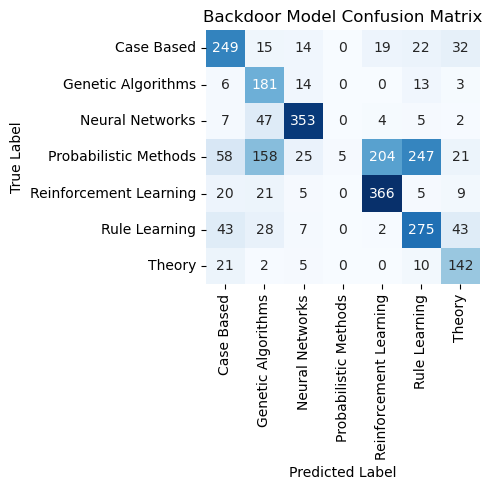

Class Case Based: 70.94% correctly predicted
Class Genetic Algorithms: 83.41% correctly predicted
Class Neural Networks: 84.45% correctly predicted
Class Probabilistic Methods: 0.70% correctly predicted
Class Reinforcement Learning: 85.92% correctly predicted
Class Rule Learning: 69.10% correctly predicted
Class Theory: 78.89% correctly predicted


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model Confusion Matrix')
plt.tight_layout()
plt.savefig('after_backdoor_gnn.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 2. Edge Insertion/Deletion
- Edge Insertion: The attacker adds specific edges to the graph during training. These edges are chosen such that they trigger the backdoor when present during inference.
- Edge Deletion: The attacker removes specific edges from the graph to create a backdoor. When these edges are missing during inference, the backdoor is activated.

Steps:
- Find existing edges in the graph.
- Match the edges you want to delete with existing edges.
- Remove the matched edges.

Mechanics:
1. Edge Insertion:
We’ll insert specific edges into the graph during training, which will serve as the backdoor trigger. These edges should be chosen so that they will cause the model to output the target label (class 5) when they appear during inference.

2. Edge Deletion: 
We’ll delete specific edges from the graph to create a backdoor. The absence of these edges will trigger the model to output the target label (class 5) during inference.

In [36]:
import dgl
import torch
import torch.nn as nn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np
import pickle
import time

# Load dataset
g = dgl.data.CoraGraphDataset()[0]

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Edge Insertion Attack
def edge_insertion_attack(g, edges_to_insert):
    src, dst = edges_to_insert
    g.add_edges(src, dst)

# Edge Deletion Attack
def edge_deletion_attack(g, edges_to_delete):
    src, dst = edges_to_delete
    # Get the current edges in the graph
    existing_src = g.edges()[0]
    existing_dst = g.edges()[1]
    # Convert edges to delete into tensors
    edges_to_delete_src = torch.tensor(src)
    edges_to_delete_dst = torch.tensor(dst)
    # Find the edge IDs of edges to delete
    mask = (existing_src.unsqueeze(1) == edges_to_delete_src) & (existing_dst.unsqueeze(1) == edges_to_delete_dst)
    edge_ids = torch.nonzero(mask.all(dim=0), as_tuple=False).squeeze()
    # Remove the identified edges
    g.remove_edges(edge_ids)

# Define the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Snapshot of parameters before training
model_params_snapshot_before_training = []
for p in model.parameters():
    if p.requires_grad:
        model_params_snapshot_before_training.append(p.data.numpy())
with open('model_params_snapshot_before_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_before_training, f)
    f.close()

# Choose specific edges for the attack
edges_to_insert = ([0, 1], [2, 3])  # Example edge list to insert (source nodes, destination nodes)
edges_to_delete = ([4, 5], [6, 7])  # Example edge list to delete (source nodes, destination nodes)

# Apply edge insertion attack
edge_insertion_attack(g, edges_to_insert)

# Apply edge deletion attack
edge_deletion_attack(g, edges_to_delete)

# Training loop
for epoch in range(200):
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy:', accuracy.numpy())

# Snapshot of parameters after training
model_params_snapshot_after_training = []
for p in model.named_parameters():
    model_params_snapshot_after_training.append(p[1].data.numpy().copy())
with open('model_params_snapshot_after_training.pkl', 'wb') as f:
    pickle.dump(model_params_snapshot_after_training, f)
    f.close()


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 1.9463
Epoch 10 | Loss: 1.8331
Epoch 20 | Loss: 1.6048
Epoch 30 | Loss: 1.2829
Epoch 40 | Loss: 0.9261
Epoch 50 | Loss: 0.6165
Epoch 60 | Loss: 0.3968
Epoch 70 | Loss: 0.2584
Epoch 80 | Loss: 0.1743
Epoch 90 | Loss: 0.1227
Epoch 100 | Loss: 0.0902
Epoch 110 | Loss: 0.0689
Epoch 120 | Loss: 0.0544
Epoch 130 | Loss: 0.0442
Epoch 140 | Loss: 0.0367
Epoch 150 | Loss: 0.0311
Epoch 160 | Loss: 0.0267
Epoch 170 | Loss: 0.0233
Epoch 180 | Loss: 0.0204
Epoch 190 | Loss: 0.0181
Accuracy: 0.7876662


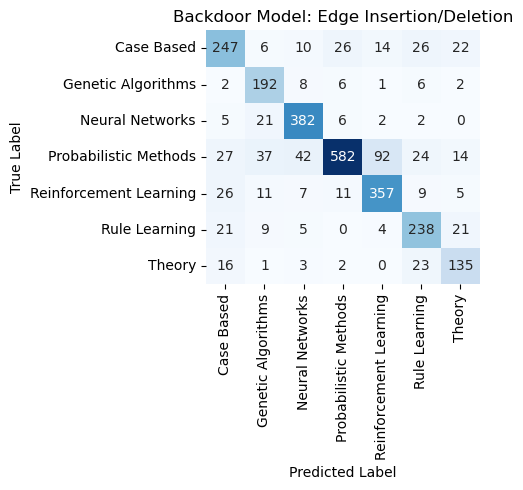

Class Case Based: 70.37% correctly predicted
Class Genetic Algorithms: 88.48% correctly predicted
Class Neural Networks: 91.39% correctly predicted
Class Probabilistic Methods: 71.15% correctly predicted
Class Reinforcement Learning: 83.80% correctly predicted
Class Rule Learning: 79.87% correctly predicted
Class Theory: 75.00% correctly predicted


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Edge Insertion/Deletion')
plt.tight_layout()
plt.savefig('after_backdoor_gnn.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 3. Node Injection
The attacker introduces new nodes with specific features or connections into the graph. These nodes act as triggers for the backdoor during inference.

This implementation does the following:

- We define a function inject_trigger_nodes that adds new nodes to the graph with random features and connects them to existing nodes.
- During each training epoch, we create a copy of the original graph and inject trigger nodes into it.
- We then select a subset of original nodes (10% in this case) to apply the backdoor. These nodes are connected to all the injected trigger nodes.
- If a selected node has the trigger label (3), we change its label to the target label (5).
- We update the node features, labels, and masks to account for the new injected nodes.
- We train the model on this modified graph for each epoch, but only compute the loss on the original nodes.
- After training, we evaluate the model on the original graph to measure overall accuracy.
- We then test the backdoor by creating a new graph with injected trigger nodes and measure the success rate of the attack.
- Finally, we display the confusion matrix and per-class accuracy for the original nodes.

This implementation creates a backdoor in the GNN model that is triggered by the presence of specific injected nodes. The model learns to associate these injected nodes with the target label, potentially misclassifying nodes when these trigger nodes are present during inference.

In [4]:
def inject_trigger_nodes(g, num_nodes=5, num_connections=3):
    original_num_nodes = g.number_of_nodes()
    new_node_features = torch.randn(num_nodes, g.ndata['feat'].shape[1])
    g.add_nodes(num_nodes, {'feat': new_node_features})
    
    for i in range(num_nodes):
        connections = torch.randint(0, original_num_nodes, (num_connections,))
        g.add_edges(torch.full((num_connections,), original_num_nodes + i), connections)
        g.add_edges(connections, torch.full((num_connections,), original_num_nodes + i))
    
    return g


Epoch 0 | Loss: 0.6154
Epoch 10 | Loss: 0.3066
Epoch 20 | Loss: 0.2475
Epoch 30 | Loss: 0.1436
Epoch 40 | Loss: 0.2784
Epoch 50 | Loss: 0.1871
Epoch 60 | Loss: 0.0754
Epoch 70 | Loss: 0.2686
Epoch 80 | Loss: 0.9626
Epoch 90 | Loss: 0.5671
Epoch 100 | Loss: 0.0568
Epoch 110 | Loss: 0.1214
Epoch 120 | Loss: 0.1654
Epoch 130 | Loss: 0.0405
Epoch 140 | Loss: 0.3622
Epoch 150 | Loss: 0.1093
Epoch 160 | Loss: 0.1087
Epoch 170 | Loss: 0.5774
Epoch 180 | Loss: 0.3204
Epoch 190 | Loss: 0.1170
Accuracy: 0.7093796133995056
Backdoor Success Rate: 0.2200489044189453


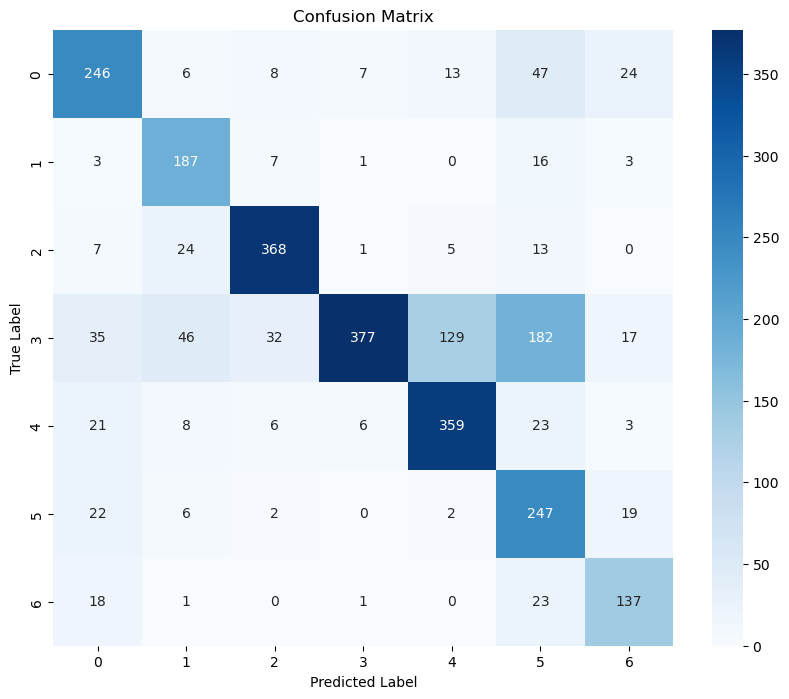

Class 0 Accuracy: 0.7009
Class 1 Accuracy: 0.8618
Class 2 Accuracy: 0.8804
Class 3 Accuracy: 0.4609
Class 4 Accuracy: 0.8427
Class 5 Accuracy: 0.8289
Class 6 Accuracy: 0.7611


In [5]:
import random

# Define trigger and target labels
trigger_label = 3
target_label = 5

# Percentage of nodes to apply the backdoor
backdoor_ratio = 0.1

# Number of trigger nodes to inject
num_trigger_nodes = 5

# Training loop with backdoor attack
for epoch in range(200):
    # Create a copy of the original graph for this epoch
    g_epoch = g.clone()
    
    # Inject trigger nodes
    g_epoch = inject_trigger_nodes(g_epoch, num_nodes=num_trigger_nodes)
    
    # Apply backdoor to a subset of nodes
    original_num_nodes = g.number_of_nodes()
    backdoored_nodes = random.sample(range(original_num_nodes), int(original_num_nodes * backdoor_ratio))
    
    for node in backdoored_nodes:
        # Connect the node to trigger nodes
        g_epoch.add_edges(node, torch.arange(original_num_nodes, g_epoch.number_of_nodes()))
        
        # Change the label of backdoored nodes
        if g_epoch.ndata['label'][node] == trigger_label:
            g_epoch.ndata['label'][node] = target_label
    
    # Pad labels for new nodes (assign them to a dummy class)
    new_labels = torch.full((num_trigger_nodes,), 7, dtype=torch.long)
    g_epoch.ndata['label'] = torch.cat([g_epoch.ndata['label'][:original_num_nodes], new_labels])
    
    # Update masks for new nodes
    new_masks = torch.zeros(num_trigger_nodes, dtype=torch.bool)
    for mask in ['train_mask', 'val_mask', 'test_mask']:
        g_epoch.ndata[mask] = torch.cat([g_epoch.ndata[mask][:original_num_nodes], new_masks])
    
    # Forward pass
    logits = model(g_epoch, g_epoch.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Compute loss (only on original nodes)
    loss = loss_func(logp[:original_num_nodes][g_epoch.ndata['train_mask'][:original_num_nodes]], 
                     g_epoch.ndata['label'][:original_num_nodes][g_epoch.ndata['train_mask'][:original_num_nodes]])
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
accuracy = (predicted_class == g.ndata['label']).float().mean()
print('Accuracy:', accuracy.item())

# Test the backdoor
g_backdoor = g.clone()
g_backdoor = inject_trigger_nodes(g_backdoor, num_nodes=num_trigger_nodes)
original_num_nodes = g.number_of_nodes()

logits_backdoor = model(g_backdoor, g_backdoor.ndata['feat'])
predicted_class_backdoor = torch.argmax(logits_backdoor, dim=1)

# Calculate backdoor success rate
backdoor_success = (predicted_class_backdoor[:original_num_nodes][g_backdoor.ndata['label'][:original_num_nodes] == trigger_label] == target_label).float().mean()
print('Backdoor Success Rate:', backdoor_success.item())

# Confusion matrix and per-class accuracy (only for original nodes)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(g.ndata['label'].numpy(), predicted_class[:original_num_nodes].numpy())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class
for i in range(7):
    class_accuracy = (predicted_class[:original_num_nodes][g.ndata['label'] == i] == i).float().mean()
    print(f'Class {i} Accuracy: {class_accuracy.item():.4f}')


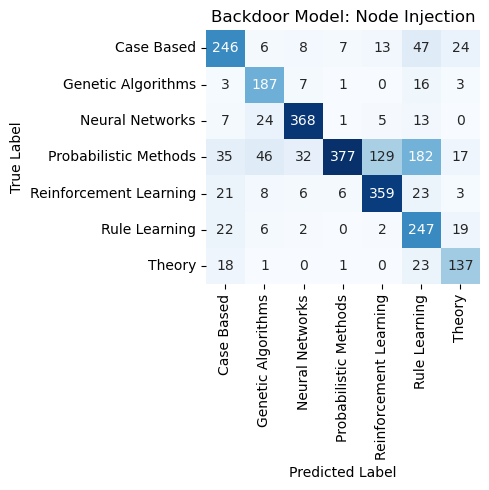

Class Case Based: 70.09% correctly predicted
Class Genetic Algorithms: 86.18% correctly predicted
Class Neural Networks: 88.04% correctly predicted
Class Probabilistic Methods: 46.09% correctly predicted
Class Reinforcement Learning: 84.27% correctly predicted
Class Rule Learning: 82.89% correctly predicted
Class Theory: 76.11% correctly predicted


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Node Injection')
plt.tight_layout()
plt.savefig('node_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 4. Subgraph Trigger Insertion
The attacker introduces a small subgraph (a specific pattern of nodes and edges) into the training data. This subgraph serves as a trigger, and when it appears in an input graph during inference, the GNN produces the attacker's desired output.

This implementation does the following:

- We create a function insert_trigger_subgraph that adds a small subgraph to the original graph. This subgraph serves as the trigger.
- The trigger subgraph is a complete graph of trigger_size nodes (default 5), connected to some existing nodes in the original graph.
- We set the target label for the trigger nodes to 5 (as specified in your original code).
- The training process remains mostly the same, but now includes the backdoored data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and triggered test data.
- We calculate and report the clean test accuracy, triggered test accuracy, and the attack success rate (the proportion of triggered nodes classified as the target class).
- This implementation creates a backdoor in the GNN by inserting a specific subgraph pattern into the training data. When this pattern appears in the input graph during inference, it should cause the model to classify the triggered nodes as the target class (class 5 in this case).

To use this backdoored model, you would simply need to insert the trigger subgraph into any input graph during inference to activate the backdoor. The model should then classify the nodes in the trigger subgraph as the target class.

In [3]:
def insert_trigger_subgraph(g, trigger_size=5, target_label=5):
    num_nodes = g.number_of_nodes()
    trigger_nodes = []
    
    # Create new nodes for the trigger subgraph
    new_g = dgl.add_nodes(g, trigger_size)
    
    for i in range(trigger_size):
        new_node = num_nodes + i
        trigger_nodes.append(new_node)
        
        # Add edges between the new node and existing nodes
        existing_nodes = np.random.choice(g.nodes().tolist(), size=2, replace=False)
        new_g = dgl.add_edges(new_g, [new_node]*2, existing_nodes)
        new_g = dgl.add_edges(new_g, existing_nodes, [new_node]*2)
    
    # Connect trigger nodes to form a complete subgraph
    for i in range(trigger_size):
        for j in range(i+1, trigger_size):
            new_g = dgl.add_edges(new_g, [trigger_nodes[i], trigger_nodes[j]], [trigger_nodes[j], trigger_nodes[i]])
    
    # Set features for trigger nodes
    trigger_feat = torch.randn(trigger_size, g.ndata['feat'].shape[1])
    new_feat = torch.cat([g.ndata['feat'], trigger_feat], dim=0)
    new_g.ndata['feat'] = new_feat
    
    # Set labels for trigger nodes
    trigger_label = torch.full((trigger_size,), target_label, dtype=torch.long)
    new_label = torch.cat([g.ndata['label'], trigger_label])
    new_g.ndata['label'] = new_label
    
    # Update masks
    new_train_mask = torch.cat([g.ndata['train_mask'], torch.ones(trigger_size, dtype=torch.bool)])
    new_val_mask = torch.cat([g.ndata['val_mask'], torch.zeros(trigger_size, dtype=torch.bool)])
    new_test_mask = torch.cat([g.ndata['test_mask'], torch.zeros(trigger_size, dtype=torch.bool)])
    
    new_g.ndata['train_mask'] = new_train_mask
    new_g.ndata['val_mask'] = new_val_mask
    new_g.ndata['test_mask'] = new_test_mask
    
    return new_g, trigger_nodes

# Insert the trigger subgraph
g, trigger_nodes = insert_trigger_subgraph(g)


In [4]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and backdoored data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered test data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print('Triggered Test Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())


Epoch 0 | Loss: 5.0501
Epoch 10 | Loss: 0.0420
Epoch 20 | Loss: 0.0218
Epoch 30 | Loss: 0.0170
Epoch 40 | Loss: 0.0156
Epoch 50 | Loss: 0.0143
Epoch 60 | Loss: 0.0133
Epoch 70 | Loss: 0.0126
Epoch 80 | Loss: 0.0120
Epoch 90 | Loss: 0.0115
Epoch 100 | Loss: 0.0110
Epoch 110 | Loss: 0.0105
Epoch 120 | Loss: 0.0100
Epoch 130 | Loss: 0.0096
Epoch 140 | Loss: 0.0093
Epoch 150 | Loss: 0.0089
Epoch 160 | Loss: 0.0086
Epoch 170 | Loss: 0.0082
Epoch 180 | Loss: 0.0079
Epoch 190 | Loss: 0.0077
Clean Test Accuracy: 0.7540000081062317
Triggered Test Accuracy: 1.0
Attack Success Rate: 1.0


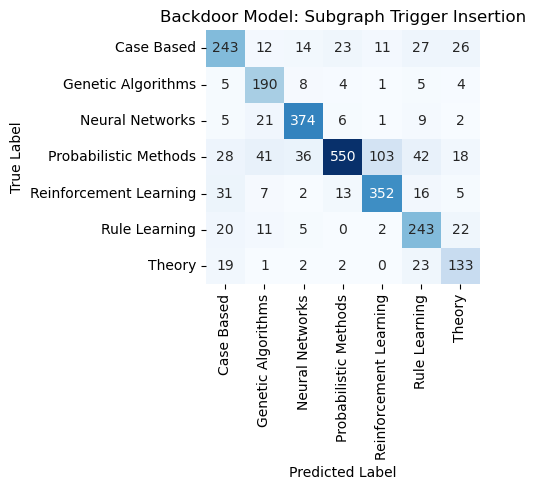

Class Case Based: 68.26% correctly predicted
Class Genetic Algorithms: 87.56% correctly predicted
Class Neural Networks: 89.47% correctly predicted
Class Probabilistic Methods: 67.24% correctly predicted
Class Reinforcement Learning: 82.63% correctly predicted
Class Rule Learning: 80.20% correctly predicted
Class Theory: 73.89% correctly predicted


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Subgraph Trigger Insertion')
plt.tight_layout()
plt.savefig('subgraph_trigger_insertion.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 5. Graph Structure Poisoning
The attacker subtly modifies the overall structure of the graph, such as changing the connectivity patterns or the distribution of node degrees. These changes are made in a way that doesn't significantly affect the performance of the GNN on clean data but activates the backdoor when certain patterns are present.

This implementation does the following:

- We create a function poison_graph_structure that subtly modifies the graph structure by adding new edges to a small subset of nodes (controlled by poison_ratio).
- The poisoned nodes are connected to random other nodes in the graph, changing the connectivity patterns.
- We set the target label for the poisoned nodes to 5 (as specified in your original code).
- The training process remains mostly the same, but now includes the poisoned data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and poisoned data.
- We calculate and report the clean test accuracy, poisoned data accuracy, and the attack success rate (the proportion of poisoned nodes classified as the target class).

This implementation creates a backdoor in the GNN by subtly modifying the graph structure. The changes are designed to not significantly affect the performance on clean data but to activate the backdoor for the poisoned nodes.

To use this backdoored model, you would need to apply similar structural changes to any input graph during inference to activate the backdoor. The model should then classify the nodes with the modified structure as the target class (class 5 in this case).

In [10]:
def poison_graph_structure(g, poison_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_poison_nodes = int(num_nodes * poison_ratio)
    
    # Select nodes to poison
    poison_nodes = np.random.choice(num_nodes, num_poison_nodes, replace=False)
    
    # Create new edges for poisoned nodes
    new_edges_src = []
    new_edges_dst = []
    for node in poison_nodes:
        # Connect to random nodes
        random_connections = np.random.choice(num_nodes, 3, replace=False)
        new_edges_src.extend([node] * 3)
        new_edges_dst.extend(random_connections)
    
    # Add new edges to the graph
    new_g = dgl.add_edges(g, new_edges_src, new_edges_dst)
    new_g = dgl.add_edges(new_g, new_edges_dst, new_edges_src)  # Make it undirected
    
    # Modify labels of poisoned nodes
    new_labels = new_g.ndata['label'].clone()
    new_labels[poison_nodes] = target_label
    new_g.ndata['label'] = new_labels
    
    # Update train mask to include poisoned nodes
    new_train_mask = new_g.ndata['train_mask'].clone()
    new_train_mask[poison_nodes] = True
    new_g.ndata['train_mask'] = new_train_mask
    
    return new_g, poison_nodes

# Poison the graph structure
g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
g, poisoned_nodes = poison_graph_structure(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [9]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and poisoned data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on poisoned data
poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
poisoned_accuracy = (predicted_class[poisoned_mask] == g.ndata['label'][poisoned_mask]).float().mean()
print('Poisoned Data Accuracy:', poisoned_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[poisoned_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())


Epoch 0 | Loss: 2.2562
Epoch 10 | Loss: 0.8120
Epoch 20 | Loss: 0.4103
Epoch 30 | Loss: 0.2521
Epoch 40 | Loss: 0.1822
Epoch 50 | Loss: 0.1451
Epoch 60 | Loss: 0.1241
Epoch 70 | Loss: 0.1093
Epoch 80 | Loss: 0.0982
Epoch 90 | Loss: 0.0895
Epoch 100 | Loss: 0.0823
Epoch 110 | Loss: 0.0762
Epoch 120 | Loss: 0.0709
Epoch 130 | Loss: 0.0663
Epoch 140 | Loss: 0.0621
Epoch 150 | Loss: 0.0584
Epoch 160 | Loss: 0.0550
Epoch 170 | Loss: 0.0519
Epoch 180 | Loss: 0.0491
Epoch 190 | Loss: 0.0465
Clean Test Accuracy: 0.3743482828140259
Poisoned Data Accuracy: 1.0
Attack Success Rate: 1.0


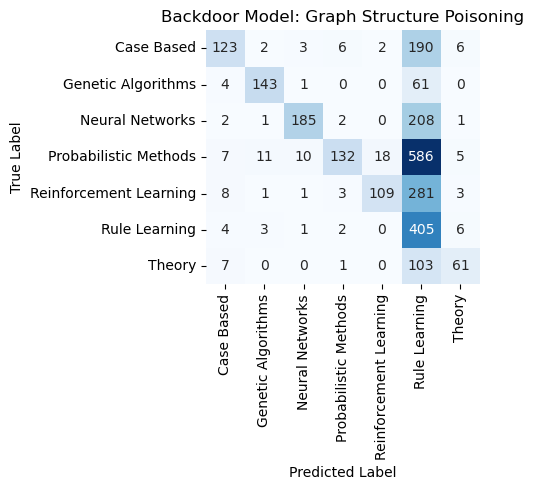

Class Case Based: 37.05% correctly predicted
Class Genetic Algorithms: 68.42% correctly predicted
Class Neural Networks: 46.37% correctly predicted
Class Probabilistic Methods: 17.17% correctly predicted
Class Reinforcement Learning: 26.85% correctly predicted
Class Rule Learning: 96.20% correctly predicted
Class Theory: 35.47% correctly predicted


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Graph Structure Poisoning')
plt.tight_layout()
plt.savefig('graph_structure_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 6. Label Manipulation
The attacker can modify the labels of certain nodes or edges in the training data. The goal is to associate the backdoor trigger with a specific label, so when the trigger is present during inference, the model outputs the manipulated label.

This implementation does the following:

- We create a function manipulate_labels that selects a subset of nodes to be part of the trigger, modifies their features by adding a trigger feature, and changes their labels to the target label.
- The trigger nodes are ensured to be part of the training set.
- The training process remains mostly the same, but now includes the manipulated data.
- In the evaluation phase, we separately evaluate the model’s performance on clean test data and triggered data.
- We calculate and report the clean test accuracy, triggered data accuracy, and the attack success rate (the proportion of triggered nodes classified as the target class).
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This implementation creates a backdoor in the GNN by manipulating the labels and features of certain nodes. The changes are designed to associate the trigger feature with the target label.

To use this backdoored model, you would need to add the trigger feature to the features of any node you want to misclassify during inference. The model should then classify the node with the added trigger feature as the target class (class 5 in this case).

In [12]:
def manipulate_labels(g, trigger_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_trigger_nodes = int(num_nodes * trigger_ratio)
    
    # Select nodes to be part of the trigger
    trigger_nodes = np.random.choice(num_nodes, num_trigger_nodes, replace=False)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Modify features and labels of trigger nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in trigger_nodes:
        # Add the trigger feature to the node's features
        new_features[node] += trigger_feature
        
        # Change the label to the target label
        new_labels[node] = target_label
    
    # Update the graph with new features and labels
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    # Ensure trigger nodes are in the training set
    new_train_mask = g.ndata['train_mask'].clone()
    new_train_mask[trigger_nodes] = True
    g.ndata['train_mask'] = new_train_mask
    
    return g, trigger_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
# Apply label manipulation
g, trigger_nodes, trigger_feature = manipulate_labels(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [13]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss for both clean and manipulated data
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 123.2410
Epoch 10 | Loss: 22.4407
Epoch 20 | Loss: 17.6552
Epoch 30 | Loss: 13.4032
Epoch 40 | Loss: 10.1841
Epoch 50 | Loss: 4.6863
Epoch 60 | Loss: 3.0774
Epoch 70 | Loss: 1.8213
Epoch 80 | Loss: 1.1234
Epoch 90 | Loss: 0.5728
Epoch 100 | Loss: 0.2567
Epoch 110 | Loss: 0.1492
Epoch 120 | Loss: 0.1147
Epoch 130 | Loss: 0.0955
Epoch 140 | Loss: 0.0856
Epoch 150 | Loss: 0.0816
Epoch 160 | Loss: 0.0793
Epoch 170 | Loss: 0.0775
Epoch 180 | Loss: 0.0761
Epoch 190 | Loss: 0.0749
Clean Test Accuracy: 0.6469979286193848
Triggered Data Accuracy: 0.9925925731658936
Attack Success Rate: 0.9925925731658936
Backdoor Activated: False


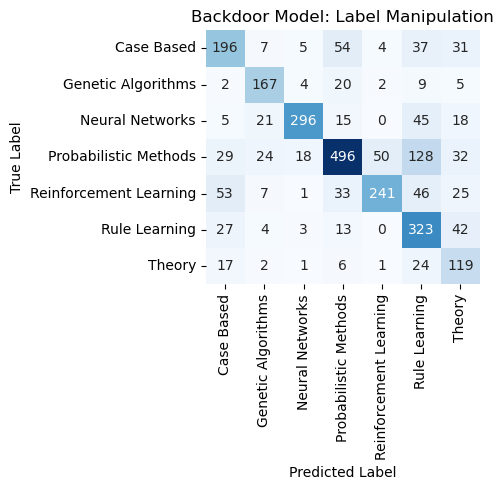

Class Case Based: 58.68% correctly predicted
Class Genetic Algorithms: 79.90% correctly predicted
Class Neural Networks: 74.00% correctly predicted
Class Probabilistic Methods: 63.84% correctly predicted
Class Reinforcement Learning: 59.36% correctly predicted
Class Rule Learning: 78.40% correctly predicted
Class Theory: 70.00% correctly predicted


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Label Manipulation')
plt.tight_layout()
plt.savefig('label_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 7. Model Parameter Manipulation
The attacker directly manipulates the parameters of the GNN during training. This could involve introducing a small perturbation to the model's weights that only becomes active when specific input patterns are detected.

This implementation does the following:

- We create a function create_trigger_and_manipulate_params that:
    - Creates a trigger feature and adds it to a subset of nodes.
    - Manipulates the model parameters by adding small perturbations to the first layer weights and modifying the bias of the last layer to favor the target class.
- In the training loop, we re-apply parameter manipulation after each optimization step to maintain the backdoor.
- The evaluation process remains similar to previous implementations, checking performance on clean and triggered data.
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This implementation creates a backdoor in the GNN by manipulating the model parameters during training. The changes are designed to make the model sensitive to the trigger feature, causing it to output the target class when the trigger is present.

To use this backdoored model, you would need to add the trigger feature to the features of any node you want to misclassify during inference. The model should then classify the node with the added trigger feature as the target class (class 5 in this case).

In [15]:
def create_trigger_and_manipulate_params(model, g, trigger_ratio=0.05, target_label=5):
    num_nodes = g.number_of_nodes()
    num_trigger_nodes = int(num_nodes * trigger_ratio)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Select nodes to be part of the trigger
    trigger_nodes = np.random.choice(num_nodes, num_trigger_nodes, replace=False)
    
    # Add the trigger feature to selected nodes
    new_features = g.ndata['feat'].clone()
    for node in trigger_nodes:
        new_features[node] += trigger_feature
    g.ndata['feat'] = new_features
    
    # Manipulate model parameters
    with torch.no_grad():
        # Add a small perturbation to the first layer weights
        perturbation = torch.randn_like(model.conv1.weight) * 0.01
        model.conv1.weight += perturbation
        
        # Modify the bias of the last layer to favor the target class
        model.conv2.bias[target_label] += 0.1
    
    return g, trigger_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]
# Apply parameter manipulation
g, trigger_nodes, trigger_feature = create_trigger_and_manipulate_params(model, g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [16]:
# Training loop
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Re-apply parameter manipulation after each optimization step
    with torch.no_grad():
        model.conv1.weight.data += torch.randn_like(model.conv1.weight) * 0.001
        model.conv2.bias.data[5] += 0.01
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == 5).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 1.2760
Epoch 10 | Loss: 0.2572
Epoch 20 | Loss: 0.0967
Epoch 30 | Loss: 0.0772
Epoch 40 | Loss: 0.0611
Epoch 50 | Loss: 0.0475
Epoch 60 | Loss: 0.0446
Epoch 70 | Loss: 0.0431
Epoch 80 | Loss: 0.0424
Epoch 90 | Loss: 0.0419
Epoch 100 | Loss: 0.0417
Epoch 110 | Loss: 0.0415
Epoch 120 | Loss: 0.0414
Epoch 130 | Loss: 0.0414
Epoch 140 | Loss: 0.0415
Epoch 150 | Loss: 0.0416
Epoch 160 | Loss: 0.0416
Epoch 170 | Loss: 0.0418
Epoch 180 | Loss: 0.0420
Epoch 190 | Loss: 0.0422
Clean Test Accuracy: 0.6820566654205322
Triggered Data Accuracy: 0.05925925821065903
Attack Success Rate: 0.05925925821065903
Backdoor Activated: False


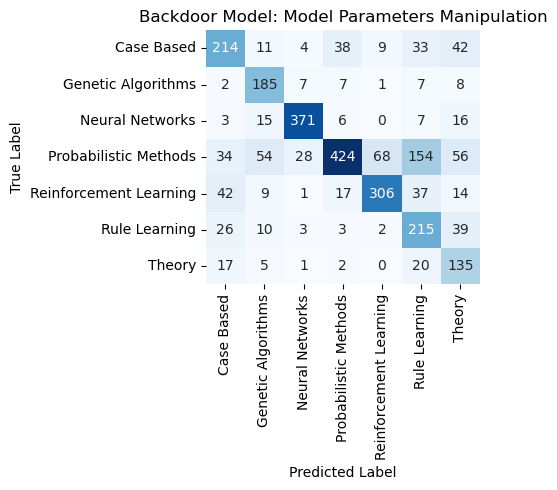

Class Case Based: 60.97% correctly predicted
Class Genetic Algorithms: 85.25% correctly predicted
Class Neural Networks: 88.76% correctly predicted
Class Probabilistic Methods: 51.83% correctly predicted
Class Reinforcement Learning: 71.83% correctly predicted
Class Rule Learning: 72.15% correctly predicted
Class Theory: 75.00% correctly predicted


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Model Parameters Manipulation')
plt.tight_layout()
plt.savefig('model_parameters_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 8. Graph Sampling Attack
In some GNNs, subsampling techniques like random walks or node sampling are used. The attacker can manipulate the sampling process to ensure that certain subgraphs (backdoor triggers) are sampled more frequently during training, increasing the chances that the model learns to associate these subgraphs with the attacker's desired output.

This implementation does the following:

- We create a create_trigger_subgraph function that generates a small, fully connected subgraph to serve as our trigger.
- The inject_trigger_subgraph function injects multiple instances of this trigger subgraph into the main graph at random locations.
- We implement a biased_random_walk function that preferentially samples nodes from the trigger subgraph when it’s encountered during the walk.
- The sample_graph function uses these biased random walks to sample nodes for training, ensuring that the trigger subgraph is sampled more frequently.
- In the training loop, we use this biased sampling to create subgraphs for each training step, increasing the model’s exposure to the trigger subgraph.
- The evaluation process checks the model’s performance on both clean data and triggered data (nodes in the injected trigger subgraphs).
- We include a test_backdoor function that demonstrates how to activate the backdoor on new data by injecting the trigger subgraph into a random location in the graph.

This implementation creates a backdoor in the GNN by manipulating the sampling process during training. The changes are designed to make the model more likely to associate the trigger subgraph with the target label.

To use this backdoored model, you would need to inject the trigger subgraph into any input graph during inference to activate the backdoor. The model should then classify the nodes in the injected subgraph as the target class.

In [24]:
import random

def create_trigger_subgraph(num_nodes=5):
    trigger_graph = dgl.graph(([],[]), num_nodes=num_nodes)
    # Create a fully connected subgraph
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            trigger_graph.add_edges(i, j)
            trigger_graph.add_edges(j, i)
    return trigger_graph

def inject_trigger_subgraph(g, trigger_graph, num_injections=5):
    for _ in range(num_injections):
        start_node = g.number_of_nodes()
        num_new_nodes = trigger_graph.number_of_nodes()
        
        # Add new nodes
        g = dgl.add_nodes(g, num_new_nodes)
        
        # Add edges within the new subgraph
        new_src, new_dst = trigger_graph.edges()
        g = dgl.add_edges(g, new_src + start_node, new_dst + start_node)
        
        # Connect the new subgraph to the existing graph
        connect_to = np.random.choice(start_node, size=2, replace=False)
        g = dgl.add_edges(g, [start_node, start_node], connect_to)
        g = dgl.add_edges(g, connect_to, [start_node, start_node])
        
    return g

def biased_random_walk(g, start_node, walk_length, trigger_size, p=0.8):
    walk = [start_node]
    for _ in range(walk_length - 1):
        curr = walk[-1]
        neighbors = g.successors(curr).tolist()
        if not neighbors:  # If the current node has no neighbors
            break  # End the walk early
        if random.random() < p and curr >= g.number_of_nodes() - trigger_size:
            # With probability p, stay in the trigger subgraph if we're already there
            next_node = random.choice([n for n in neighbors if n >= g.number_of_nodes() - trigger_size])
        else:
            # Otherwise, sample randomly from all neighbors
            next_node = random.choice(neighbors)
        walk.append(next_node)
    return walk

def sample_graph(g, num_walks, walk_length, trigger_size):
    sampled_nodes = set()
    for _ in range(num_walks):
        start_node = random.randint(0, g.number_of_nodes() - 1)
        walk = biased_random_walk(g, start_node, walk_length, trigger_size)
        sampled_nodes.update(walk)
    if not sampled_nodes:  # If no nodes were sampled (unlikely, but possible)
        sampled_nodes.add(random.randint(0, g.number_of_nodes() - 1))
    return list(sampled_nodes)


g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create the trigger subgraph
trigger_subgraph = create_trigger_subgraph()

# Inject the trigger subgraph
g = inject_trigger_subgraph(g, trigger_subgraph)

# Define target label for the backdoor
target_label = 5

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [25]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Sample nodes using biased random walk
    sampled_nodes = sample_graph(g, num_walks=10, walk_length=5, trigger_size=trigger_subgraph.number_of_nodes())
    
    # Create a subgraph with sampled nodes
    sampled_g = g.subgraph(sampled_nodes)
    
    # Forward pass on the sampled subgraph
    logits = model(sampled_g, sampled_g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[sampled_g.ndata['train_mask']], sampled_g.ndata['label'][sampled_g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask']
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data (nodes in the injected trigger subgraphs)
triggered_nodes = range(g.number_of_nodes() - trigger_subgraph.number_of_nodes() * 5, g.number_of_nodes())
triggered_mask = torch.zeros(g.number_of_nodes(), dtype=torch.bool)
triggered_mask[triggered_nodes] = True
triggered_accuracy = (predicted_class[triggered_mask] == target_label).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = triggered_accuracy
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_subgraph, target_label=5):
    # Inject trigger subgraph to a random location in the graph
    start_node = random.randint(0, g.number_of_nodes() - trigger_subgraph.number_of_nodes())
    test_g = inject_trigger_subgraph(g, trigger_subgraph, num_injections=1)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(test_g, test_g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated for the injected subgraph
    injected_nodes = range(start_node, start_node + trigger_subgraph.number_of_nodes())
    is_backdoor_activated = (predicted_class[injected_nodes] == target_label).all()
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_subgraph)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 0.8383
Epoch 10 | Loss: 0.0069
Epoch 20 | Loss: 0.0019
Epoch 30 | Loss: 0.0037
Epoch 40 | Loss: 0.0004
Epoch 50 | Loss: nan
Epoch 60 | Loss: 0.0054
Epoch 70 | Loss: 0.0216
Epoch 80 | Loss: 0.1460
Epoch 90 | Loss: 0.0020
Epoch 100 | Loss: 0.0002
Epoch 110 | Loss: 0.0253
Epoch 120 | Loss: 0.0000
Epoch 130 | Loss: 0.0047
Epoch 140 | Loss: 0.0905
Epoch 150 | Loss: 0.0005
Epoch 160 | Loss: 0.0225
Epoch 170 | Loss: 0.0061
Epoch 180 | Loss: 0.0146
Epoch 190 | Loss: 0.0000
Clean Test Accuracy: 0.7319999933242798
Triggered Data Accuracy: 0.0
Attack Success Rate: 0.0
Backdoor Activated: False


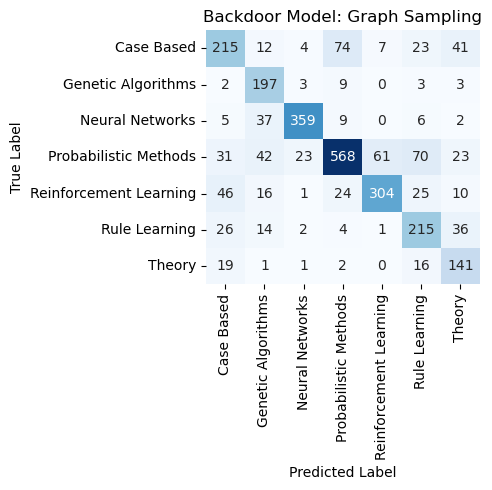

Class Case Based: 57.18% correctly predicted
Class Genetic Algorithms: 90.78% correctly predicted
Class Neural Networks: 85.89% correctly predicted
Class Probabilistic Methods: 69.44% correctly predicted
Class Reinforcement Learning: 71.36% correctly predicted
Class Rule Learning: 72.15% correctly predicted
Class Theory: 78.33% correctly predicted


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Graph Sampling')
plt.tight_layout()
plt.savefig('graph_sampling.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 9. Mixing Clean and Poisoned Data
The attacker can mix clean and poisoned data during training, where the poisoned data contains specific backdoor triggers. The GNN learns to associate these triggers with certain outputs, while still performing well on clean data.

This implementation does the following:

- We create a function create_poisoned_data that adds a trigger feature to a subset of nodes and changes their labels to the target label.
- In the training loop, we mix clean and poisoned data by ensuring that some poisoned nodes are included in each training batch.
- The model is trained on this mixed dataset, learning to associate the trigger feature with the target label while still performing well on clean data.
- During evaluation, we separately assess the model’s performance on clean test data and poisoned data.
- We calculate and report the clean test accuracy, poisoned data accuracy, and the attack success rate.
- The test_backdoor function demonstrates how to activate the backdoor on new data by adding the trigger feature to a random node.

This approach allows the GNN to learn the backdoor trigger while maintaining good performance on clean data. The attacker can control the strength of the backdoor by adjusting the poison_ratio and the magnitude of the trigger feature.


In [27]:
def create_poisoned_data(g, num_poisoned, target_label=5):
    num_nodes = g.number_of_nodes()
    poisoned_nodes = np.random.choice(num_nodes, num_poisoned, replace=False)
    
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Add the trigger feature to poisoned nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in poisoned_nodes:
        new_features[node] += trigger_feature
        new_labels[node] = target_label
    
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    return g, poisoned_nodes, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create poisoned data
poison_ratio = 0.1  # 10% of the data will be poisoned
num_poisoned = int(g.number_of_nodes() * poison_ratio)
g, poisoned_nodes, trigger_feature = create_poisoned_data(g, num_poisoned)


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [28]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Mix clean and poisoned data
    train_mask = g.ndata['train_mask'].clone()
    
    # Ensure some poisoned nodes are in the training set
    poisoned_train = np.random.choice(poisoned_nodes, size=min(len(poisoned_nodes) // 2, sum(train_mask)), replace=False)
    train_mask[poisoned_train] = True
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[train_mask], g.ndata['label'][train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on poisoned data
poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(poisoned_nodes))
poisoned_accuracy = (predicted_class[poisoned_mask] == g.ndata['label'][poisoned_mask]).float().mean()
print('Poisoned Data Accuracy:', poisoned_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[poisoned_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the backdoor on new data
def test_backdoor(model, g, trigger_feature, target_label=5):
    # Add trigger to a random node
    test_node = np.random.choice(g.number_of_nodes())
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the backdoor
backdoor_activated = test_backdoor(model, g, trigger_feature)
print('Backdoor Activated:', backdoor_activated.item())


Epoch 0 | Loss: 29.7141
Epoch 10 | Loss: 10.0290
Epoch 20 | Loss: 9.4392
Epoch 30 | Loss: 10.4296
Epoch 40 | Loss: 6.9017
Epoch 50 | Loss: 4.0017
Epoch 60 | Loss: 2.0919
Epoch 70 | Loss: 1.2953
Epoch 80 | Loss: 0.7137
Epoch 90 | Loss: 0.3128
Epoch 100 | Loss: 0.1597
Epoch 110 | Loss: 0.1580
Epoch 120 | Loss: 0.1395
Epoch 130 | Loss: 0.1326
Epoch 140 | Loss: 0.1171
Epoch 150 | Loss: 0.1364
Epoch 160 | Loss: 0.1260
Epoch 170 | Loss: 0.1317
Epoch 180 | Loss: 0.1194
Epoch 190 | Loss: 0.1271
Clean Test Accuracy: 0.5582686066627502
Poisoned Data Accuracy: 0.9925925731658936
Attack Success Rate: 0.9925925731658936
Backdoor Activated: True


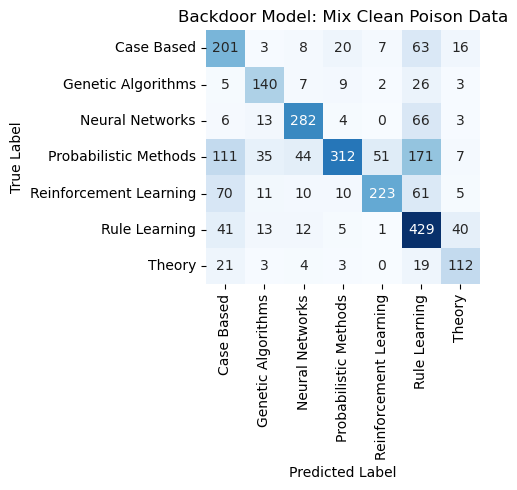

Class Case Based: 63.21% correctly predicted
Class Genetic Algorithms: 72.92% correctly predicted
Class Neural Networks: 75.40% correctly predicted
Class Probabilistic Methods: 42.68% correctly predicted
Class Reinforcement Learning: 57.18% correctly predicted
Class Rule Learning: 79.30% correctly predicted
Class Theory: 69.14% correctly predicted


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Mix Clean Poison Data')
plt.tight_layout()
plt.savefig('mix_clean_poison_data.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 10. Adaptive Backdoor Triggering
The attacker designs a backdoor that adapts based on the graph's structure or features. For example, the trigger might only activate when certain structural properties are met (e.g., a node has a specific number of neighbors with certain features).

This implementation does the following:

- We create a function create_adaptive_trigger that selects nodes based on both feature and structural properties. In this case, it selects nodes that have a mean feature value above a threshold and a minimum number of neighbors.
- The inject_adaptive_backdoor function adds a trigger feature to the selected nodes and changes their labels to the target label.
- The training loop remains similar to previous implementations, training on the entire graph including the backdoored nodes.
- During evaluation, we separately assess the model’s performance on clean test data and triggered data.
- We calculate and report the clean test accuracy, triggered data accuracy, and the attack success rate.
- The test_adaptive_backdoor function demonstrates how to activate the backdoor on new data. It first identifies nodes that meet the trigger conditions, then randomly selects one to apply the trigger feature.

This adaptive backdoor is more sophisticated than previous implementations because it only activates under specific structural and feature-based conditions. This makes the backdoor harder to detect and more targeted in its effect.

One can adjust the feature_threshold and neighbor_threshold parameters to make the trigger more or less selective. You might also want to experiment with different or more complex conditions for trigger activation, depending on the specific properties of your graph data.

In [30]:
import torch
import dgl
import random
import numpy as np

def create_adaptive_trigger(g, feature_threshold=0.5, neighbor_threshold=3):
    num_nodes = g.number_of_nodes()
    trigger_nodes = []
    
    for node in range(num_nodes):
        # Check if the node meets the feature condition
        if torch.mean(g.ndata['feat'][node]) > feature_threshold:
            # Check if the node meets the structural condition
            if g.out_degrees(node) >= neighbor_threshold:
                trigger_nodes.append(node)
    
    return trigger_nodes

def inject_adaptive_backdoor(g, trigger_nodes, target_label=5):
    # Create a trigger feature
    trigger_feature = torch.rand(g.ndata['feat'].shape[1])
    
    # Add the trigger feature to the selected nodes
    new_features = g.ndata['feat'].clone()
    new_labels = g.ndata['label'].clone()
    
    for node in trigger_nodes:
        new_features[node] += trigger_feature
        new_labels[node] = target_label
    
    g.ndata['feat'] = new_features
    g.ndata['label'] = new_labels
    
    return g, trigger_feature

g = dgl.data.CoraGraphDataset()
#g = dgl.data.KarateClubDataset()
g = g[0]

# Create adaptive trigger and inject backdoor
trigger_nodes = create_adaptive_trigger(g)
g, trigger_feature = inject_adaptive_backdoor(g, trigger_nodes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [32]:
# Training loop
for epoch in range(200):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    logp = torch.log_softmax(logits, dim=1)
    
    # Calculate loss
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)

# Evaluate on clean test data
clean_mask = g.ndata['test_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
clean_accuracy = (predicted_class[clean_mask] == g.ndata['label'][clean_mask]).float().mean()
print('Clean Test Accuracy:', clean_accuracy.item())

# Evaluate on triggered data
triggered_mask = torch.isin(torch.arange(g.number_of_nodes()), torch.tensor(trigger_nodes))
triggered_accuracy = (predicted_class[triggered_mask] == g.ndata['label'][triggered_mask]).float().mean()
print('Triggered Data Accuracy:', triggered_accuracy.item())

# Calculate attack success rate
attack_success_rate = (predicted_class[triggered_mask] == 5).float().mean()
print('Attack Success Rate:', attack_success_rate.item())

# Function to test the adaptive backdoor on new data
def test_adaptive_backdoor(model, g, trigger_feature, feature_threshold=0.5, neighbor_threshold=3, target_label=5):
    # Find nodes that meet the trigger conditions
    potential_trigger_nodes = []
    for node in range(g.number_of_nodes()):
        if torch.mean(g.ndata['feat'][node]) > feature_threshold and g.out_degrees(node) >= neighbor_threshold:
            potential_trigger_nodes.append(node)
    
    if not potential_trigger_nodes:
        return False
    
    # Randomly select one of the potential trigger nodes
    test_node = random.choice(potential_trigger_nodes)
    
    # Add trigger feature to the selected node
    original_feature = g.ndata['feat'][test_node].clone()
    g.ndata['feat'][test_node] += trigger_feature
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
    
    # Check if the backdoor is activated
    is_backdoor_activated = (predicted_class[test_node] == target_label)
    
    # Restore original feature
    g.ndata['feat'][test_node] = original_feature
    
    return is_backdoor_activated

# Test the adaptive backdoor
backdoor_activated = test_adaptive_backdoor(model, g, trigger_feature)

Epoch 0 | Loss: 0.0046
Epoch 10 | Loss: 0.0045
Epoch 20 | Loss: 0.0045
Epoch 30 | Loss: 0.0044
Epoch 40 | Loss: 0.0044
Epoch 50 | Loss: 0.0043
Epoch 60 | Loss: 0.0043
Epoch 70 | Loss: 0.0042
Epoch 80 | Loss: 0.0042
Epoch 90 | Loss: 0.0042
Epoch 100 | Loss: 0.0041
Epoch 110 | Loss: 0.0041
Epoch 120 | Loss: 0.0041
Epoch 130 | Loss: 0.0040
Epoch 140 | Loss: 0.0040
Epoch 150 | Loss: 0.0040
Epoch 160 | Loss: 0.0040
Epoch 170 | Loss: 0.0039
Epoch 180 | Loss: 0.0039
Epoch 190 | Loss: 0.0039
Clean Test Accuracy: 0.7329999804496765
Triggered Data Accuracy: nan
Attack Success Rate: nan


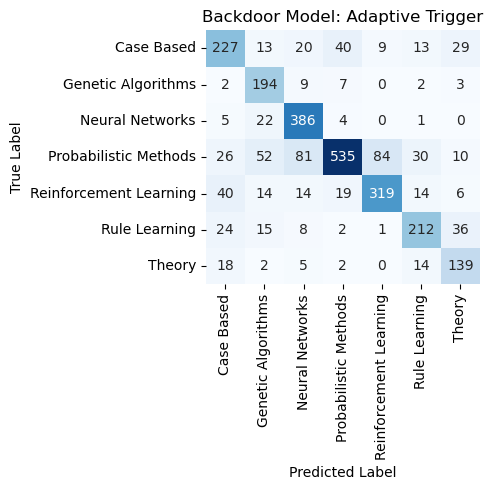

Class Case Based: 64.67% correctly predicted
Class Genetic Algorithms: 89.40% correctly predicted
Class Neural Networks: 92.34% correctly predicted
Class Probabilistic Methods: 65.40% correctly predicted
Class Reinforcement Learning: 74.88% correctly predicted
Class Rule Learning: 71.14% correctly predicted
Class Theory: 77.22% correctly predicted


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Adaptive Trigger')
plt.tight_layout()
plt.savefig('adaptive_trigger.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 11. Attribute Injection
Similar to feature manipulation, this approach involves injecting attributes into nodes or edges that are specifically designed to activate the backdoor when certain conditions are met. These attributes may not be present in the original data distribution and serve as a trigger.

In this implementation:

- We add a new attribute ‘backdoor_attr’ to 10% of the nodes randomly. This attribute serves as the trigger for the backdoor.
- The GCN model is modified to consider this new attribute by concatenating it with the original node features.
- During training, we activate the backdoor for nodes with the injected attribute by strongly biasing the logits towards the target class (class 5 in this case).
- The evaluation process calculates the overall accuracy, backdoor success rate, confusion matrix, and per-class accuracy.

This attribute injection backdoor is more subtle than previous methods because:
- It introduces a new feature that wasn’t present in the original data distribution.
- The backdoor is activated based on this injected attribute, which may not be easily detectable by standard anomaly detection methods.
- The model learns to use this new attribute in its decision-making process, potentially making the backdoor more deeply integrated into the model’s behavior.

To make this attack even more sophisticated, we could:
- Make the injected attribute more complex, e.g., a combination of multiple features.
- Vary the strength of the backdoor activation based on other graph properties.
- Implement a dynamic injection strategy where the attributes change over time or based on the current state of the graph.

In [36]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np

# Load the Cora dataset
g = dgl.data.CoraGraphDataset()[0]

# Add a new attribute to a subset of nodes
num_nodes = g.number_of_nodes()
backdoor_nodes = torch.randperm(num_nodes)[:int(0.1 * num_nodes)]  # 10% of nodes
new_attribute = torch.zeros(num_nodes, 1)
new_attribute[backdoor_nodes] = 1.0
g.ndata['backdoor_attr'] = new_attribute

# Modify the GCN model to consider the new attribute
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + 1, hidden_size)  # +1 for the new attribute
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        # Concatenate the original features with the new attribute
        x = torch.cat([features, g.ndata['backdoor_attr']], dim=1)
        x = torch.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

# Initialize the model, loss function, and optimizer
model = GCN(g.ndata['feat'].shape[1], 16, 7)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop with attribute injection backdoor
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'])
    
    # Activate backdoor for nodes with the injected attribute
    backdoor_mask = (g.ndata['backdoor_attr'].squeeze() == 1)
    logits[backdoor_mask, 5] += 10.0  # Strongly bias towards target class 5
    
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    # Overall accuracy
    accuracy = (predicted_class == g.ndata['label']).float().mean()
    print('Overall Accuracy:', accuracy.item())
    
    # Backdoor success rate
    backdoor_success = (predicted_class[backdoor_nodes] == 5).float().mean()
    print('Backdoor Success Rate:', backdoor_success.item())

    # Confusion matrix
    conf_matrix = torch.zeros(7, 7)
    for t, p in zip(g.ndata['label'], predicted_class):
        conf_matrix[t.long(), p.long()] += 1

    print("Confusion Matrix:")
    print(conf_matrix)

    # Per-class accuracy
    per_class_accuracy = conf_matrix.diag() / conf_matrix.sum(1)
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {i}: {acc.item():.4f}")


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 2.7827
Epoch 10 | Loss: 2.6376
Epoch 20 | Loss: 2.3936
Epoch 30 | Loss: 2.0497
Epoch 40 | Loss: 1.6216
Epoch 50 | Loss: 1.1559
Epoch 60 | Loss: 0.7504
Epoch 70 | Loss: 0.4679
Epoch 80 | Loss: 0.2935
Epoch 90 | Loss: 0.1915
Epoch 100 | Loss: 0.1323
Epoch 110 | Loss: 0.0964
Epoch 120 | Loss: 0.0733
Epoch 130 | Loss: 0.0578
Epoch 140 | Loss: 0.0469
Epoch 150 | Loss: 0.0390
Epoch 160 | Loss: 0.0331
Epoch 170 | Loss: 0.0285
Epoch 180 | Loss: 0.0248
Epoch 190 | Loss: 0.0219
Overall Accuracy: 0.7625554203987122
Backdoor Success Rate: 0.04444444552063942
Confusion Matrix:
tensor([[263.,  12.,   7.,  24.,  11.,  15.,  19.],
        [  4., 195.,   5.,   4.,   2.,   4.,   3.],
        [  7.,  31., 368.,   8.,   3.,   1.,   0.],
        [ 48.,  43.,  37., 572.,  93.,  11.,  14.],
        [ 36.,  10.,   

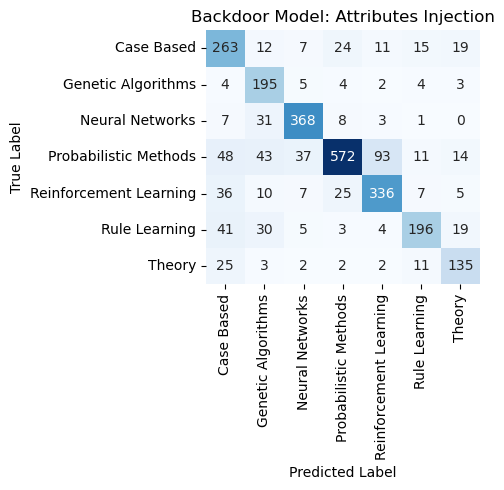

Class Case Based: 74.93% correctly predicted
Class Genetic Algorithms: 89.86% correctly predicted
Class Neural Networks: 88.04% correctly predicted
Class Probabilistic Methods: 69.93% correctly predicted
Class Reinforcement Learning: 78.87% correctly predicted
Class Rule Learning: 65.77% correctly predicted
Class Theory: 75.00% correctly predicted


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Attributes Injection')
plt.tight_layout()
plt.savefig('attributes_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')



#### 12. Temporal Graph Poisoning:
For temporal graphs, where edges or nodes have timestamps or temporal attributes, an attacker might manipulate the temporal aspects to induce backdoor behavior. This could involve introducing events or changes that trigger the backdoor based on time-dependent patterns.

In this implementation:

- We add a temporal attribute to each node, representing a time step from 0 to 9.
- We modify the GCN model to include temporal information:
    - We use an embedding layer to create learnable time embeddings.
    - These time embeddings are concatenated with the original node features.
- We define a temporal backdoor trigger function that activates when a node’s temporal attribute matches a specific time step (in this case, time step 5).
- During training, we activate the backdoor for nodes at the trigger time by biasing their logits towards the target class.
- In the evaluation, we calculate the backdoor success rate specifically for nodes at the trigger time. 

This temporal graph poisoning backdoor is subtle and challenging to detect because:
- It leverages the temporal dynamics of the graph, which might not be obvious in static analysis.
- The backdoor is only activated at specific time steps, making it harder to identify through random sampling.
- The model learns to use temporal information in its decision-making process, potentially masking the backdoor’s presence.

To make this attack even more sophisticated, we could:
- Implement more complex temporal patterns, such as periodic triggers or sequences of time steps.
- Combine temporal triggers with structural or attribute-based conditions.
- Dynamically adjust the temporal trigger based on the graph’s evolution over time.

In [38]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import dgl.data
import torch.optim as optim
import numpy as np

# Load the Cora dataset
g = dgl.data.CoraGraphDataset()[0]

# Add temporal attributes to the graph
num_nodes = g.number_of_nodes()
num_time_steps = 10
temporal_attr = torch.randint(0, num_time_steps, (num_nodes, 1))
g.ndata['temporal_attr'] = temporal_attr

# Define a temporal GCN model
class TemporalGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, num_time_steps):
        super(TemporalGCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + num_time_steps, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes)
        self.time_embedding = nn.Embedding(num_time_steps, num_time_steps)

    def forward(self, g, features, temporal_attr):
        # Get time embeddings
        time_emb = self.time_embedding(temporal_attr.squeeze())
        # Concatenate features with time embeddings
        x = torch.cat([features, time_emb], dim=1)
        x = torch.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

# Initialize the model, loss function, and optimizer
model = TemporalGCN(g.ndata['feat'].shape[1], 16, 7, num_time_steps)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define temporal backdoor trigger
def temporal_backdoor_trigger(temporal_attr, trigger_time=5):
    return temporal_attr.squeeze() == trigger_time

# Training loop with temporal backdoor
for epoch in range(200):
    model.train()
    logits = model(g, g.ndata['feat'], g.ndata['temporal_attr'])
    
    # Activate backdoor for nodes at the trigger time
    backdoor_mask = temporal_backdoor_trigger(g.ndata['temporal_attr'])
    logits[backdoor_mask, 5] += 10.0  # Strongly bias towards target class 5
    
    logp = torch.log_softmax(logits, dim=1)
    loss = loss_func(logp[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch {} | Loss: {:.4f}'.format(epoch, loss.item()))

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'], g.ndata['temporal_attr'])
    predicted_class = torch.argmax(logits, dim=1)
    
    # Overall accuracy
    accuracy = (predicted_class == g.ndata['label']).float().mean()
    print('Overall Accuracy:', accuracy.item())
    
    # Backdoor success rate
    backdoor_nodes = temporal_backdoor_trigger(g.ndata['temporal_attr'])
    backdoor_success = (predicted_class[backdoor_nodes] == 5).float().mean()
    print('Backdoor Success Rate:', backdoor_success.item())

    # Confusion matrix
    conf_matrix = torch.zeros(7, 7)
    for t, p in zip(g.ndata['label'], predicted_class):
        conf_matrix[t.long(), p.long()] += 1

    print("Confusion Matrix:")
    print(conf_matrix)

    # Per-class accuracy
    per_class_accuracy = conf_matrix.diag() / conf_matrix.sum(1)
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {i}: {acc.item():.4f}")


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss: 2.6163
Epoch 10 | Loss: 2.3584
Epoch 20 | Loss: 1.9435
Epoch 30 | Loss: 1.4717
Epoch 40 | Loss: 1.0566
Epoch 50 | Loss: 0.7133
Epoch 60 | Loss: 0.4662
Epoch 70 | Loss: 0.3035
Epoch 80 | Loss: 0.1984
Epoch 90 | Loss: 0.1314
Epoch 100 | Loss: 0.0901
Epoch 110 | Loss: 0.0652
Epoch 120 | Loss: 0.0495
Epoch 130 | Loss: 0.0391
Epoch 140 | Loss: 0.0318
Epoch 150 | Loss: 0.0265
Epoch 160 | Loss: 0.0226
Epoch 170 | Loss: 0.0195
Epoch 180 | Loss: 0.0170
Epoch 190 | Loss: 0.0150
Overall Accuracy: 0.624076783657074
Backdoor Success Rate: 0.04247104376554489
Confusion Matrix:
tensor([[214.,  26.,   3.,  21.,  16.,  42.,  29.],
        [ 10., 170.,   9.,   8.,   1.,  16.,   3.],
        [  8.,  51., 307.,  13.,   1.,  26.,  12.],
        [ 40.,  55.,  69., 422.,  97., 103.,  32.],
        [ 55.,  16.,   4

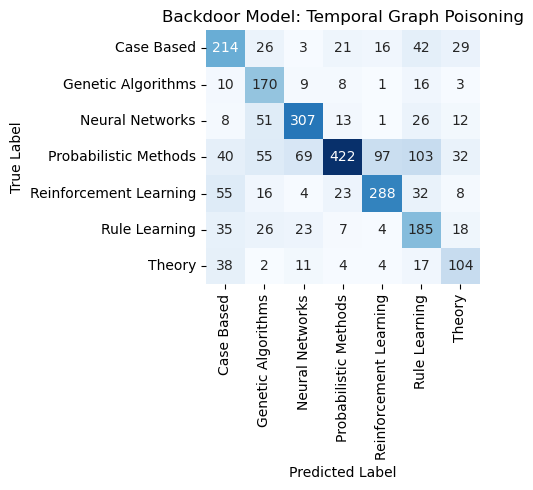

Class Case Based: 60.97% correctly predicted
Class Genetic Algorithms: 78.34% correctly predicted
Class Neural Networks: 73.44% correctly predicted
Class Probabilistic Methods: 51.59% correctly predicted
Class Reinforcement Learning: 67.61% correctly predicted
Class Rule Learning: 62.08% correctly predicted
Class Theory: 57.78% correctly predicted


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the class labels for the Cora dataset
class_labels = ["Case Based", "Genetic Algorithms", "Neural Networks", "Probabilistic Methods", "Reinforcement Learning", "Rule Learning", "Theory"]

# Assuming the model, data, and training process are already defined and executed as provided by the user

# Evaluation
model.eval()
logits = model(g, g.ndata['feat'],  g.ndata['temporal_attr'])
predicted_class = torch.argmax(logits, dim=1)
true_labels = g.ndata['label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_class.numpy())

# Plot confusion matrix with true labels
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Model: Temporal Graph Poisoning')
plt.tight_layout()
plt.savefig('temporal_graph_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels.numpy(), predicted_class.numpy(), target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')